In [1]:
# Forecasting Shanghai Index using LSTM
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from pandas import DataFrame
from pandas import concat
from itertools import chain
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# converting data for supervised learning
def get_train_set(data_set, timesteps_in, timesteps_out=1):
    train_data_set = np.array(data_set)
    reframed_train_data_set = np.array(series_to_supervised(train_data_set, timesteps_in, timesteps_out).values)
    print(reframed_train_data_set)
    print(reframed_train_data_set.shape)
    train_x, train_y = reframed_train_data_set[:, :-timesteps_out], reframed_train_data_set[:, -timesteps_out:]
    # reshaping data:[sample size, time step, features]
    train_x = train_x.reshape((train_x.shape[0], timesteps_in, 1))
    return train_x, train_y

"""
 converting time series data for supervised learning:
 define length for input and output series
 data:observed series
 n_in:observations' input(x) step, range [1,len(data)], default=1
 n_out:observations's output(x) step,range[0,len(data)-1],default =1 
 dropna:drop nan row
 return: dataframe that suits supervised learning
 """
def series_to_supervised(data, n_in=1, n_out=1, dropna=True):
   n_vars = 1 if type(data) is list else data.shape[1]
   df = DataFrame(data)
   cols,names = list(),list()
   # input sequence(t-n, . . ., t-1)
   for i in range(n_in,0,-1):
       cols.append(df.shift(i))
       names +=[('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]
   #forcast array (t, t+1, ... t+n)
   for i in range(0,n_out):
      cols.append(df.shift(-i)) 
      if i ==0:
          names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
      else:
          names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
   #append
   agg =concat(cols,axis=1)
   agg.columns=names
   #drop nan
   if dropna:
       agg.dropna(inplace=True)
   return agg



In [4]:
# forecasting
def lstm_model(source_data_set, train_x, label_y, input_epochs, input_batch_size, timesteps_out):
    model = Sequential()
    
    # 1st layer: hide, nodes=128, return to the whole sequences
    model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(train_x.shape[1], train_x.shape[2])))
    # 2nd，hide, nodes=128, only return sequence's last output
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.5))
    # 3rd, regression, linear
    model.add(Dense(timesteps_out, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # LSTM training,# input_epochs, verbose = 2 (2: ecch epoch has one row of output record, =1 output processing record,  =0 no record)
    res = model.fit(train_x, label_y, epochs=input_epochs, batch_size=input_batch_size, verbose=2, shuffle=False)

    # forecasting
    train_predict = model.predict(train_x)
    #test_data_list = list(chain(*test_data))
    train_predict_list = list(chain(*train_predict))

    plt.plot(res.history['loss'], label='train')
    plt.show()
    print(model.summary())
    plot_img(source_data_set, train_predict)

# show original, trained, tested and forcasted results
def plot_img(source_data_set, train_predict):
    plt.figure(figsize=(24, 8))
    # plot original data in blue
    plt.plot(source_data_set[:, -1], c='b')
    # plot train data in green
    plt.plot([x for x in train_predict], c='g')
    plt.legend()
    plt.show()

 
   

[[  99.98    104.39    109.13    114.55    120.25    125.27  ]
 [ 104.39    109.13    114.55    120.25    125.27    125.28  ]
 [ 109.13    114.55    120.25    125.27    125.28    126.45  ]
 ...
 [2992.8968 3011.6657 3071.6771 3034.5113 2943.2907 2996.7618]
 [3011.6657 3071.6771 3034.5113 2943.2907 2996.7618 2968.5174]
 [3071.6771 3034.5113 2943.2907 2996.7618 2968.5174 2923.4856]]
(7140, 6)
Epoch 1/500
72/72 - 1s - loss: 4934512.5000
Epoch 2/500
72/72 - 1s - loss: 4892957.0000
Epoch 3/500
72/72 - 1s - loss: 4859402.0000
Epoch 4/500
72/72 - 1s - loss: 4826824.5000
Epoch 5/500
72/72 - 1s - loss: 4795275.0000
Epoch 6/500
72/72 - 1s - loss: 4763895.0000
Epoch 7/500
72/72 - 1s - loss: 4733158.0000
Epoch 8/500
72/72 - 1s - loss: 4702294.5000
Epoch 9/500
72/72 - 1s - loss: 4671429.0000
Epoch 10/500
72/72 - 1s - loss: 4641742.0000
Epoch 11/500
72/72 - 1s - loss: 4612398.0000
Epoch 12/500
72/72 - 1s - loss: 4583063.0000
Epoch 13/500
72/72 - 1s - loss: 4552933.5000
Epoch 14/500
72/72 - 1s - loss

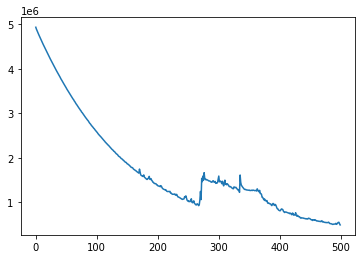

No handles with labels found to put in legend.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 128)            66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 198,531
Trainable params: 198,531
Non-trainable params: 0
_________________________________________________________________
None


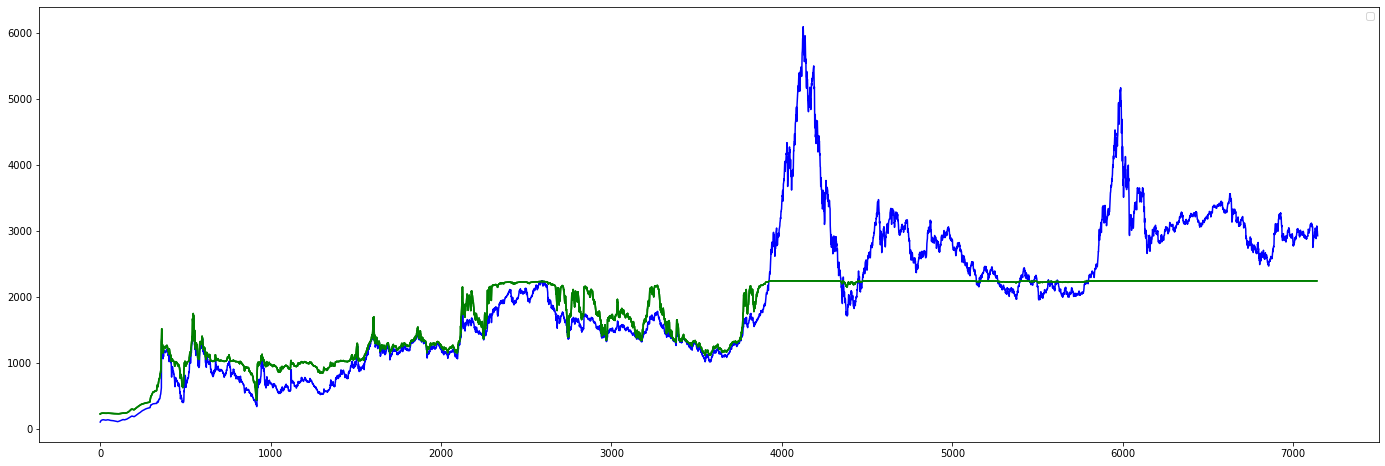

In [5]:
# set observations input(X)'s timestep，epochs，batch_size
timesteps_in = 3
timesteps_out = 3
epochs = 500
batch_size = 100
 
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/shanghai_index_1990_12_19_to_2020_03_12.csv')
 
data_set = data[['Price']].values.astype('float64')
# converting data for supervised learning
train_x, label_y = get_train_set(data_set, timesteps_in=timesteps_in, timesteps_out=timesteps_out)

# use LSTM for training and forecasting
lstm_model(data_set, train_x, label_y, epochs, batch_size, timesteps_out=timesteps_out)